In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys

pypsapath = "C:/dev/py/PyPSA/"
datapath = "../../data/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

%load_ext autoreload
%autoreload 2

In [2]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [3]:
from pathlib import Path
import json
import re

datadir = "C:/dev/grid-analysis/data/armafits"

## SciGRID dataset

In [4]:
csv_folder_name = datapath + "raw/scigrid-with-load-gen-trafos/"

if not Path(csv_folder_name).exists():
    raise Warning("SciGRID data not found. Make sure that you have downloaded the dataset corretly, and that the path is set correctly in this script.")

In [5]:
#rcParams["figure.dpi"]=300
plt.rcParams['figure.figsize'] = [12, 6]
matplotlib.rcParams.update({'font.size': 12})

In [6]:
network = pypsa.Network(import_name=csv_folder_name)
network.generators.carrier = network.generators.source

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, generators, lines, loads, storage_units, transformers


In [1]:
dir(network)

NameError: name 'network' is not defined

In [7]:
bus_names = list(network.buses.index)
bus_names_220_suffix = [n for n in bus_names if n[-6:]=="_220kV"]
suffix_removed = [n[:-6] for n in bus_names_220_suffix]
pairs = list(zip(suffix_removed, bus_names_220_suffix))

pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows')


generator_buses = network.generators.bus.unique()

n = len(generator_buses)
m = len(network.lines)

# N:
new_nodes = sorted(list(generator_buses))


def node_index(bus_name):
    if bus_name in suffix_removed:
        return node_index(bus_name + "_220kV")
    return new_nodes.index(bus_name)

# L:
new_lines = [(node_index(a),node_index(b)) for i,a,b in network.lines[['bus0','bus1']].itertuples()]

operating_voltage_lines = network.lines.voltage.values

In [8]:
T = len(network.generators_t.p_max_pu)

solar_capacity = np.zeros(n)
solar_generation = np.zeros((n,T))
wind_capacity = np.zeros(n)
wind_generation = np.zeros((n,T))

offshorebuses = set()


x, y = list(network.generators_t.p_max_pu.iteritems())[0]

node_index(network.generators.bus[x])

for gen_name, series in network.generators_t.p_max_pu.iteritems():
    carrier = network.generators.carrier[gen_name]
    busname = network.generators.bus[gen_name]
    capacity = network.generators.p_nom[gen_name]
    
    nodeindex = node_index(busname)
    
    if carrier == "Solar":
        solar_generation[nodeindex,:] += series.values * capacity
        solar_capacity[nodeindex] += capacity
    elif carrier[0:4] == "Wind":
        wind_generation[nodeindex,:] += series.values * capacity
        wind_capacity[nodeindex] += capacity
        if carrier == "Wind Offshore":
            offshorebuses.add(nodeindex)

isdaylighthour = np.sum(solar_generation, axis=0) > 0.0

In [9]:
t = network.generators_t.p_max_pu.index

## R `arima` results

In [10]:
def jsoncontents(f):
    with f.open() as ff:
        return json.JSONDecoder().decode(ff.read())

def seriesofmonth(m, carrier):
    def validfilename(s):
        return s.endswith("noise.json") or s.endswith("SANN.json") or (s.endswith(".json") and re.search("\\d\\.json", s) is not None)
    files = (f for f in (m/Path(carrier)).iterdir() if validfilename(f.name))
    
    interpreted = [jsoncontents(f) for f in files]
    # In Python, bus indices start at 0
    return dict((result["bus"][0] - 1, result) for result in interpreted)

monthnames = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
months = [datadir/Path(mn) for mn in monthnames]

monthlengths = [len(jsoncontents((m/Path("wind")).iterdir().__next__())["residuals"]) for m in months]
monthstarts = [sum(monthlengths[:i]) for i in range(13)]

## Analysis

In [11]:
mi = 0

solar_monthseries = seriesofmonth(months[mi], "solar_ML_SANN")
wind_monthseries = seriesofmonth(months[mi], "wind")

solar_noised = {i for i in solar_monthseries if "noise" in solar_monthseries[i]}
wind_noised = {i for i in wind_monthseries if "noise" in wind_monthseries[i]}

solar_generationmonth = solar_generation[:,monthstarts[mi]:monthstarts[mi+1]]
wind_generationmonth = wind_generation[:,monthstarts[mi]:monthstarts[mi+1]]

tmonth = t[monthstarts[mi]:monthstarts[mi+1]]

isdaylighthourmonth = isdaylighthour[monthstarts[mi]:monthstarts[mi+1]]

In [12]:
def randompair(nmax): 
    i = np.random.randint(nmax)
    j = np.random.randint(nmax - 1)
    j += j >= i
    return i, j

def samplecovariance(x, y):
    return np.dot(x - np.mean(x), y - np.mean(y)) / (len(x) - 1)

## Two random buses for a single carrier

In [13]:
A, B = randompair(n)

for name, index in [("A",A), ("B",B)]:
    if(index in offshorebuses):
        print("{0} is offshore".format(name))
    print("{0}={1} capacity: {2:.1f}MW solar, {3:.1f}MW wind".format(name, index, solar_capacity[index], wind_capacity[index]))

A=42 capacity: 12.7MW solar, 5.7MW wind
B=219 capacity: 6.8MW solar, 21.4MW wind


In [14]:
carrier = ["wind", "solar_ML_SANN"][1]

if carrier == "wind":
    monthseries = wind_monthseries
    generationmonth = wind_generationmonth
    capacity = wind_capacity
    noised = wind_noised
else:
    monthseries = solar_monthseries
    generationmonth = solar_generationmonth
    capacity = solar_capacity
    noised = solar_noised

In [15]:
resA = monthseries[A]["residuals"]
resB = monthseries[B]["residuals"]

genA = generationmonth[A,:]
genB = generationmonth[B,:]
capA = capacity[A]
capB = capacity[B]

assert(monthseries[A]["bus"][0] == A + 1)
assert(monthseries[B]["bus"][0] == B + 1)

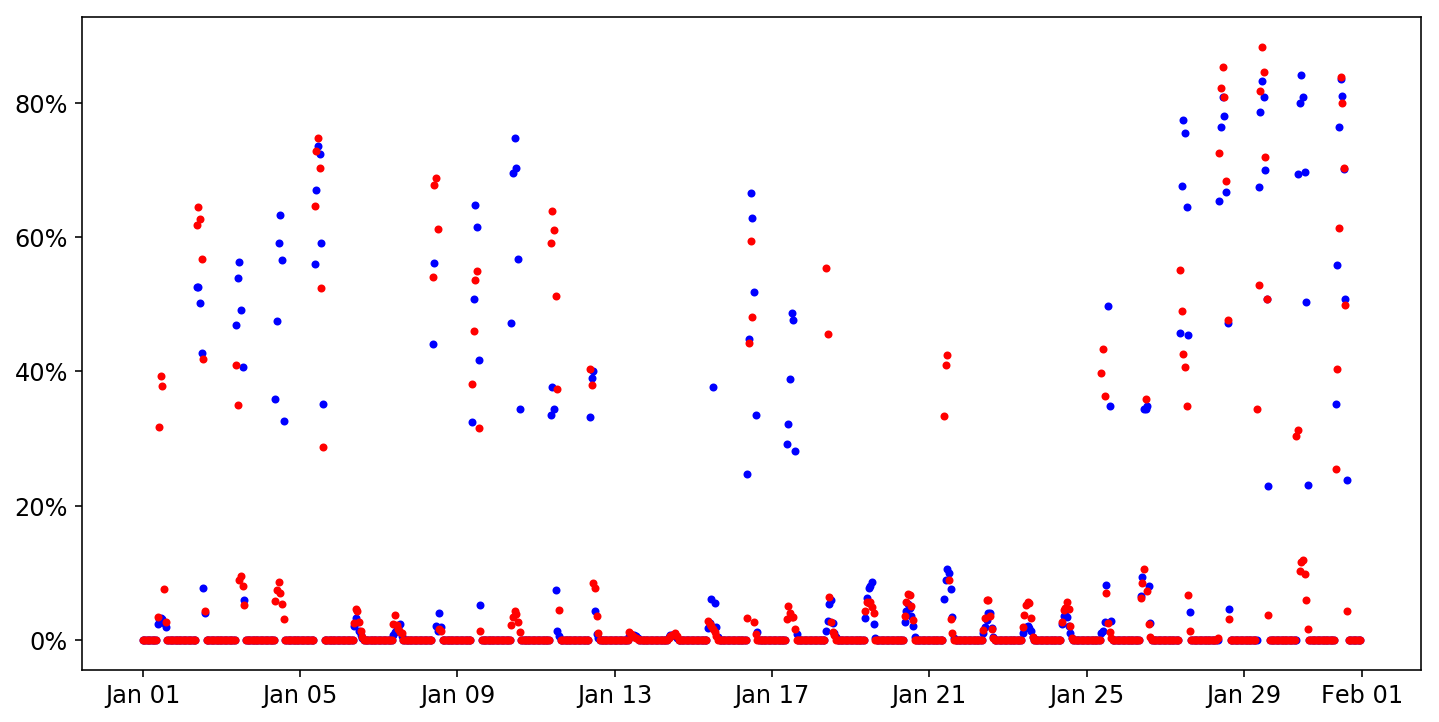

In [16]:
fig, ax = plt.subplots()
ax.plot(tmonth, genA / capA, ".", c="b")
ax.plot(tmonth, genB / capB, ".", c="r")
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %d"))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(True))
#https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

Text(0.9, 0.1, 'cov = 1.97')

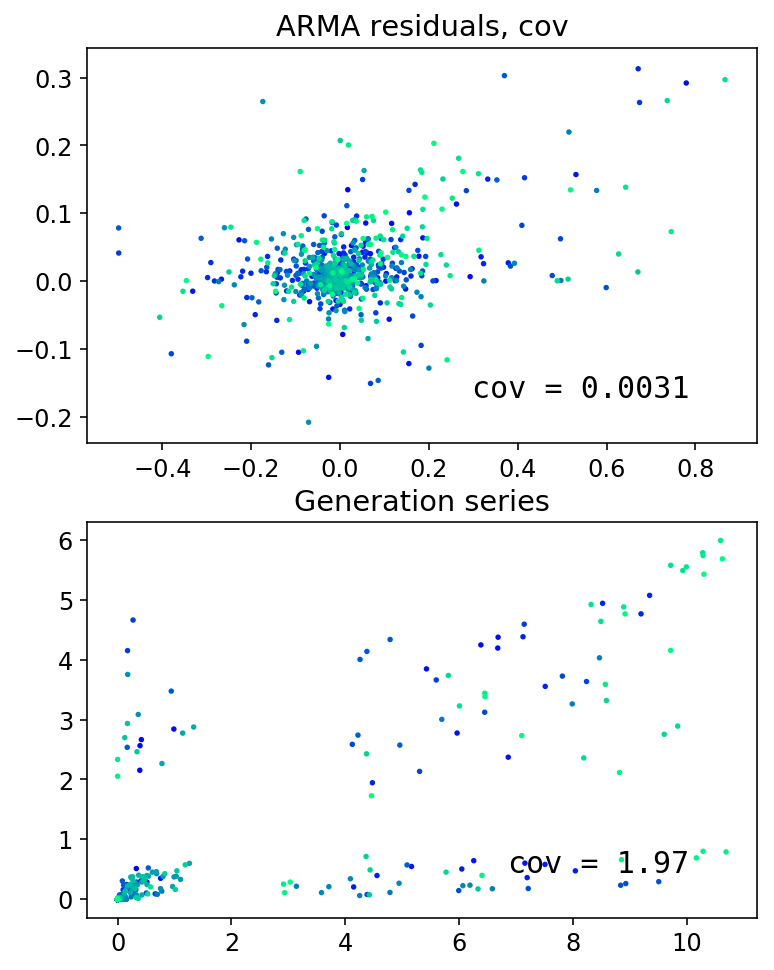

In [17]:
font = matplotlib.font_manager.FontProperties(family="monospace")

#plt.rc('text', usetex=False)

fig, ax = plt.subplots(2,1, figsize=(6,8))
ax[0].scatter(resA, resB, s=3, c=np.linspace(0, 1, num=len(resA)), cmap="winter")
ax[1].scatter(genA, genB, s=3, c=np.linspace(0, 1, num=len(resA)), cmap="winter")

ax[0].set_title("ARMA residuals, cov")
ax[1].set_title("Generation series")

rescovAB = samplecovariance(resA, resB)
gencovAB = samplecovariance(genA, genB)
ax[0].text(0.9, 0.1, "cov = {:.3g}".format(rescovAB), horizontalalignment="right", verticalalignment="bottom", transform=ax[0].transAxes, fontproperties=font, fontsize=15)
ax[1].text(0.9, 0.1, "cov = {:.3g}".format(gencovAB), horizontalalignment="right", verticalalignment="bottom", transform=ax[1].transAxes, fontproperties=font, fontsize=15)

# Covariance matrices, both carriers (solar+wind)

In [53]:
solar_res = np.array([solar_monthseries[i]["residuals"] if i in solar_monthseries else np.zeros(monthlengths[mi]) for i in range(n)])
solar_gen = solar_generationmonth
wind_res = np.array([wind_monthseries[i]["residuals"] if i in wind_monthseries else np.zeros(monthlengths[mi]) for i in range(n)])
wind_gen = wind_generationmonth

solar_rescov = np.cov(solar_res)
solar_gencov = np.cov(solar_gen)
wind_rescov = np.cov(wind_res)
wind_gencov = np.cov(wind_gen)

with np.errstate(divide='ignore'):
    solar_invcapacity = 1/solar_capacity
    solar_invcapacity[solar_capacity==0.0] = 0.0
    wind_invcapacity = 1/wind_capacity
    wind_invcapacity[wind_capacity==0.0] = 0.0
#

solar_resshufflednorm = np.array(solar_invcapacity[:,np.newaxis]*solar_res)
np.random.shuffle(solar_resshufflednorm)
wind_resshufflednorm = np.array(wind_invcapacity[:,np.newaxis]*wind_res)
np.random.shuffle(wind_resshufflednorm)


solar_gencovnorm = np.cov(solar_invcapacity[:,np.newaxis]*solar_gen)
solar_rescovnorm = np.cov(solar_invcapacity[:,np.newaxis]*solar_res)
solar_resshuffledcovnorm = np.cov(solar_resshufflednorm)
solar_resdaylightcovnorm = np.cov((solar_invcapacity[:,np.newaxis]*solar_res)[:,isdaylighthourmonth])
solar_gendaylightcovnorm = np.cov((solar_invcapacity[:,np.newaxis]*solar_gen)[:,isdaylighthourmonth])

wind_gencovnorm = np.cov(wind_invcapacity[:,np.newaxis]*wind_gen)
wind_rescovnorm = np.cov(wind_invcapacity[:,np.newaxis]*wind_res)
wind_resshuffledcovnorm = np.cov(wind_resshufflednorm)

solar_resdaylightcov = np.cov(solar_res[:,isdaylighthourmonth])
solar_gendaylightcov = np.cov(solar_gen[:,isdaylighthourmonth])

In [63]:
savepath = Path(datapath)/"processed"

if not savepath.exists():
    savepath.mkdir()

np.savetxt(savepath/"solar_resdaylightcov.csv", solar_resdaylightcov, delimiter=",")
np.savetxt(savepath/"solar_gendaylightcov.csv", solar_gendaylightcov, delimiter=",")
np.savetxt(savepath/"solar_capacity.csv", solar_capacity, delimiter=",")
np.savetxt(savepath/"wind_gencov.csv", wind_gencov, delimiter=",")
np.savetxt(savepath/"wind_rescov.csv", wind_rescov, delimiter=",")
np.savetxt(savepath/"wind_capacity.csv", wind_capacity, delimiter=",")

np.save(savepath/"solar_resdaylightcov.npy", solar_resdaylightcov, allow_pickle=False)
np.save(savepath/"solar_gendaylightcov.npy", solar_gendaylightcov, allow_pickle=False)
np.save(savepath/"solar_capacity.npy", solar_capacity, allow_pickle=False)
np.save(savepath/"wind_gencov.npy", wind_gencov, allow_pickle=False)
np.save(savepath/"wind_rescov.npy", wind_rescov, allow_pickle=False)
np.save(savepath/"wind_capacity.npy", wind_capacity, allow_pickle=False)


WindowsPath('C:/dev/grid-analysis/data/processed')

Let's pick 10000 random bus pairs, and examine their covariances.

In [19]:
num = 10000
np.random.seed(12345)
randompairs = [randompair(n) for _ in range(num)]


solar_genconvs = np.array([solar_gencovnorm[i,j] for i,j in randompairs])
solar_resconvs = np.array([solar_rescovnorm[i,j] for i,j in randompairs])
solar_resconvsshuffled = np.array([solar_resshuffledcovnorm[i,j] for i,j in randompairs])
solar_gendaylightconvs = np.array([solar_gendaylightcovnorm[i,j] for i,j in randompairs])
solar_resdaylightconvs = np.array([solar_resdaylightcovnorm[i,j] for i,j in randompairs])

wind_genconvs = np.array([wind_gencovnorm[i,j] for i,j in randompairs])
wind_resconvs = np.array([wind_rescovnorm[i,j] for i,j in randompairs])
wind_resconvsshuffled = np.array([wind_resshuffledcovnorm[i,j] for i,j in randompairs])

solar_isnoisedpair = [i in solar_noised or j in solar_noised for i,j in randompairs]
wind_isnoisedpair = [i in wind_noised or j in wind_noised for i,j in randompairs]

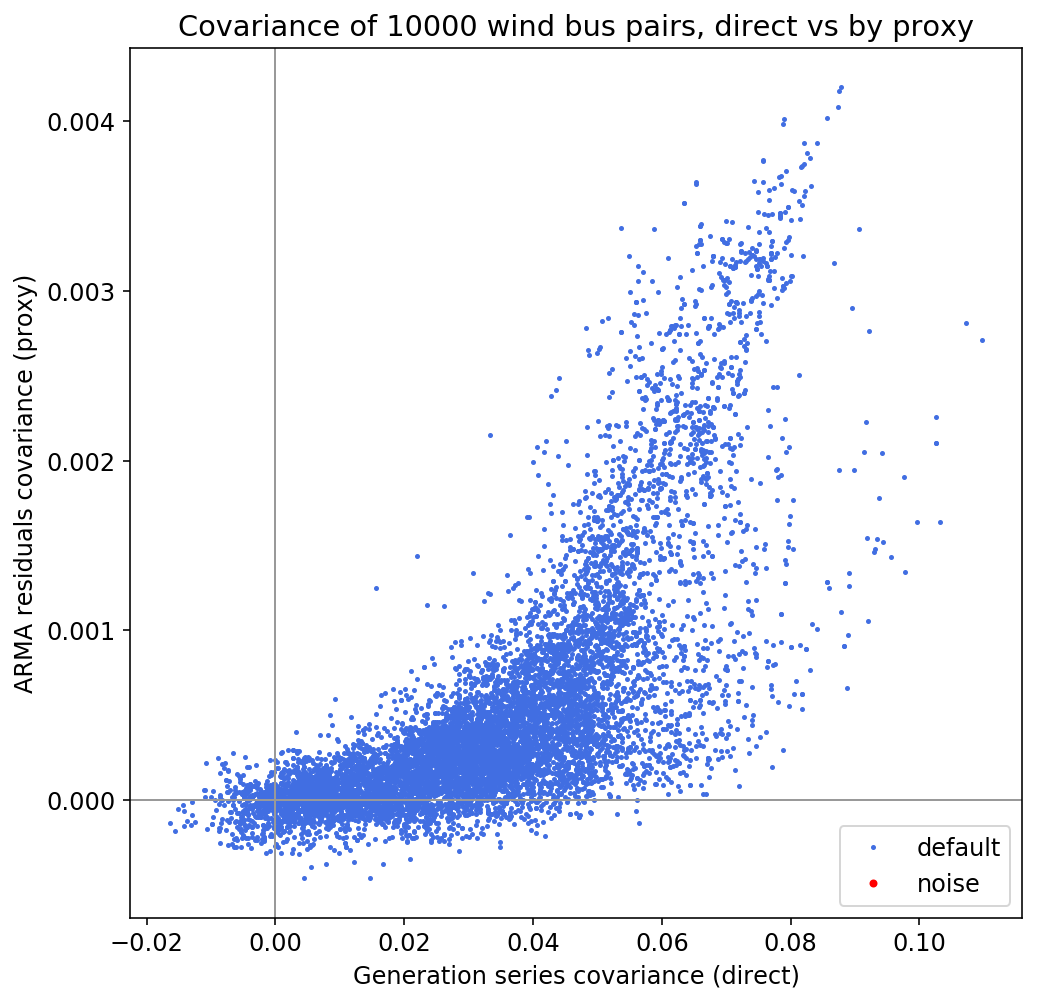

In [47]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(wind_genconvs, wind_resconvs, ".", markersize = 3, c="#416ee2", label="default")
ax.plot(wind_genconvs[wind_isnoisedpair], wind_resconvs[wind_isnoisedpair], ".", markersize = 6, c="r", label="noise")
#ax.plot(solar_genconvs, solar_resconvsshuffled, ".", markersize=1, c="r", label="shuffled")

ax.set_title("Covariance of {0} wind bus pairs, direct vs by proxy".format(num))
ax.set_xlabel("Generation series covariance (direct)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

#ax.set_xlim(0,0.05)
#ax.set_ylim(0,0.0002)
ax.axhline(0.0, c="#999999", linewidth=1)
ax.axvline(0.0, c="#999999", linewidth=1)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))


(-1e-05, 0.0001)

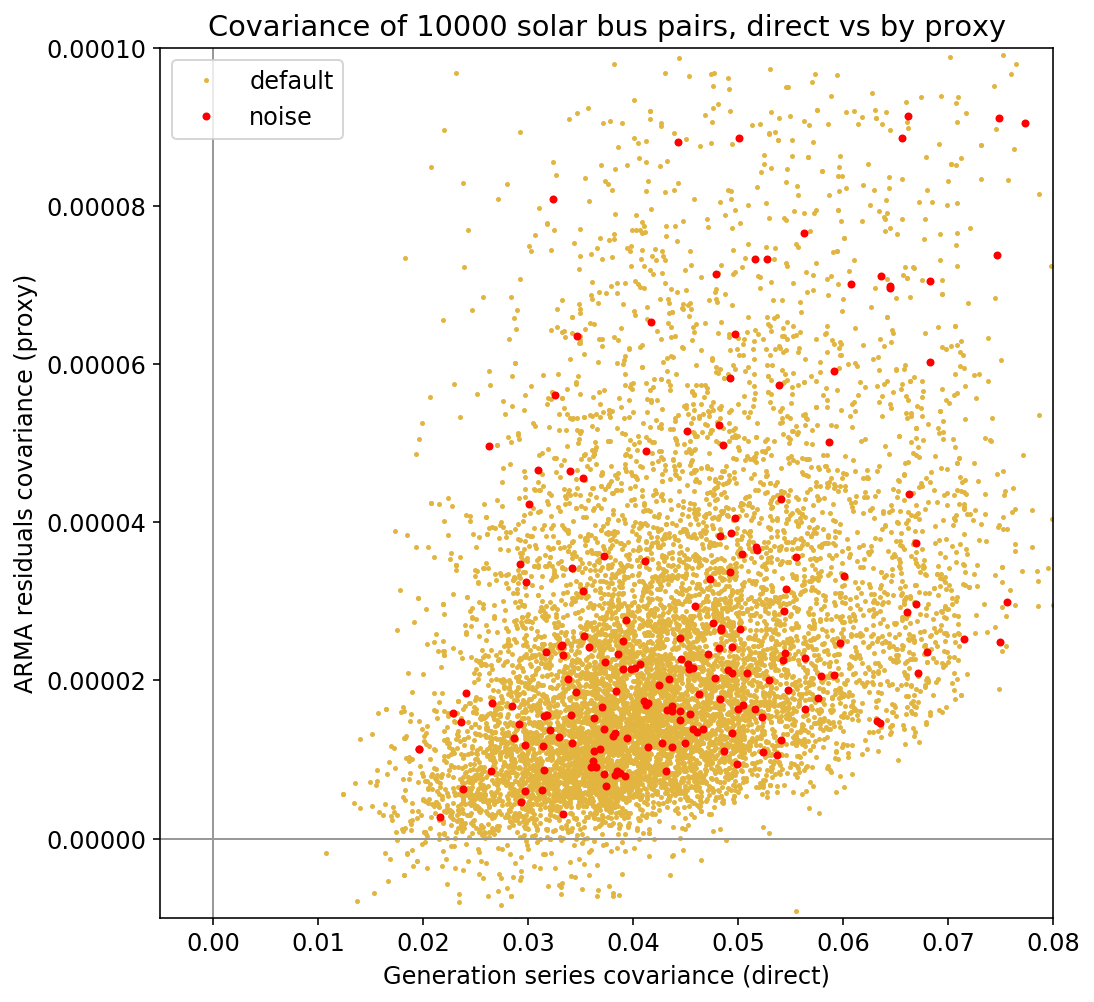

In [46]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(solar_gendaylightconvs, solar_resdaylightconvs, ".", markersize = 3, c="#e2b541", label="default")
ax.plot(solar_gendaylightconvs[solar_isnoisedpair], solar_resdaylightconvs[solar_isnoisedpair], ".", markersize = 6, c="r", label="noise")
#ax.plot(solar_genconvs, solar_resconvsshuffled, ".", markersize=1, c="r", label="shuffled")

ax.set_title("Covariance of {0} solar bus pairs, direct vs by proxy".format(num))
ax.set_xlabel("Generation series covariance (direct)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

ax.axhline(0.0, c="#999999", linewidth=1)
ax.axvline(0.0, c="#999999", linewidth=1)

ax.set_xlim(-0.005,0.08)
ax.set_ylim(-0.00001,0.0001)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))


(0, 0.0001)

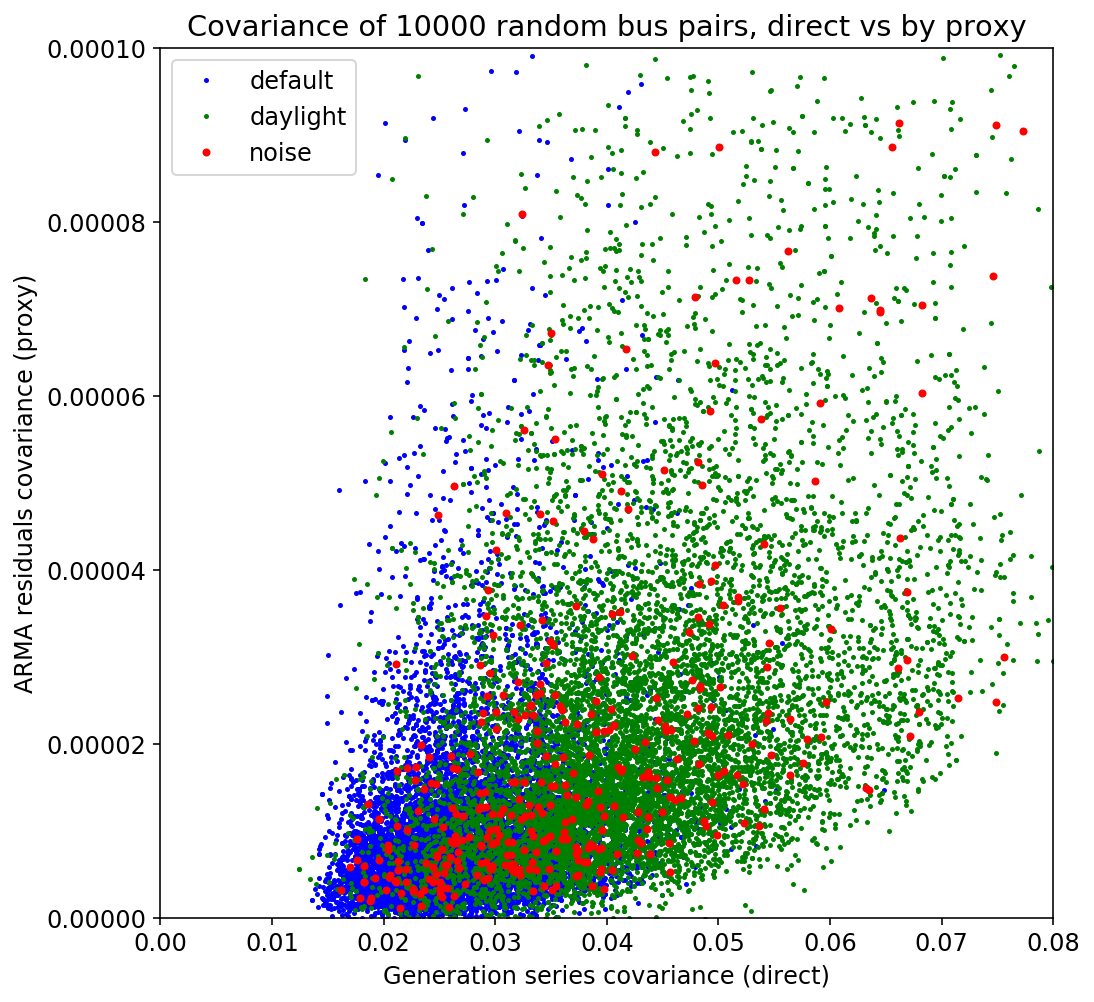

In [21]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(solar_genconvs, solar_resconvs, ".", markersize = 3, c="b", label="default")
ax.plot(solar_gendaylightconvs, solar_resdaylightconvs, ".", markersize = 3, c="g", label="daylight")
ax.plot(solar_genconvs[solar_isnoisedpair], solar_resconvs[solar_isnoisedpair], ".", markersize = 6, c="r", label="noise")
ax.plot(solar_gendaylightconvs[solar_isnoisedpair], solar_resdaylightconvs[solar_isnoisedpair], ".", markersize = 6, c="r")
#ax.plot(solar_genconvs, solar_resconvsshuffled, ".", markersize=1, c="r", label="shuffled")

ax.set_title("Covariance of {0} solar bus pairs, direct vs by proxy".format(num))
ax.set_xlabel("Generation series covariance (direct)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

ax.set_xlim(0,0.08)
ax.set_ylim(0,0.0001)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))


# Relation: distance - correlation

In [22]:
locations = pd.DataFrame(network.buses.loc[new_nodes][["x","y"]])
locations.index = range(n)

s = lambda z: z*z

lon2km = lambda deg: np.cos(50 * np.pi/180) * 40000 * (deg / 360)
lat2km = lambda deg: 40000 * (deg / 360)

dist = lambda a,b: np.sqrt(s(lon2km(locations.x[a] - locations.x[b]))+s(lat2km(locations.y[a] - locations.y[b])))
dists = list(itertools.starmap(dist, randompairs))

Text(0, 0.5, 'Distance (km)')

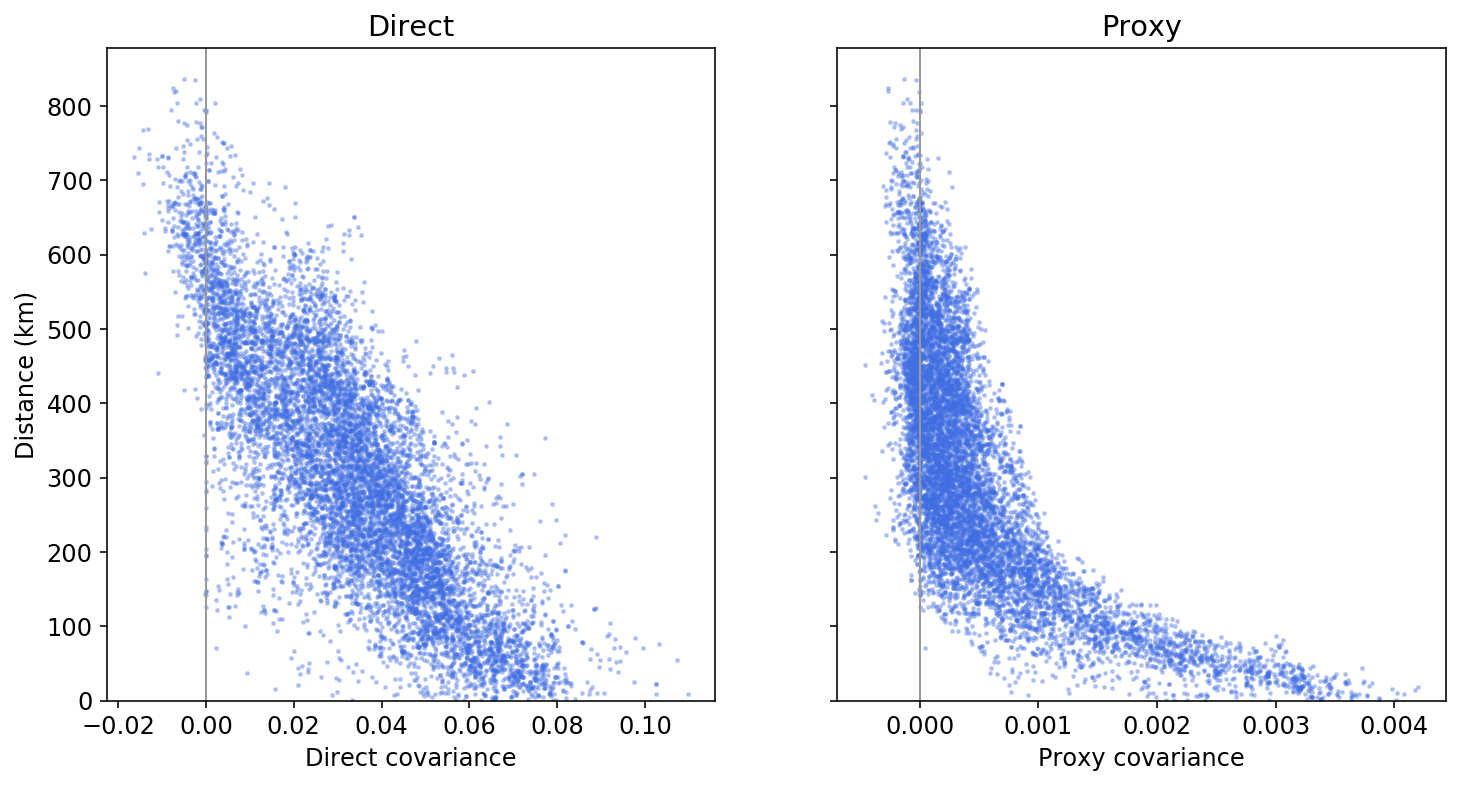

In [31]:
def set_ymin_to_zero(ax):
    a,b = ax.get_ylim()
    ax.set_ylim(0.0,b)

fig, ax = plt.subplots(1,2,figsize=(12,6),sharey=True)

plotargs = {"markersize":3, "c":"#416ee2", "alpha":0.3}

ax[0].plot(wind_genconvs, dists, ".", **plotargs)
#ax[0,0].set_xlim(0.01, 0.09)
ax[1].plot(wind_resconvs, dists, ".", **plotargs)
#ax[0,1].set_xlim(-0.00001, 0.00005)

ax[0].axvline(0.0, c="#999999", linewidth=1)
ax[1].axvline(0.0, c="#999999", linewidth=1)

set_ymin_to_zero(ax[0])
set_ymin_to_zero(ax[1])

ax[0].set_title("Direct")
ax[1].set_title("Proxy")

ax[0].set_xlabel("Direct covariance")
ax[1].set_xlabel("Proxy covariance")
ax[0].set_ylabel("Distance (km)")

Text(0.5, 1.0, 'Proxy, only daylight hours')

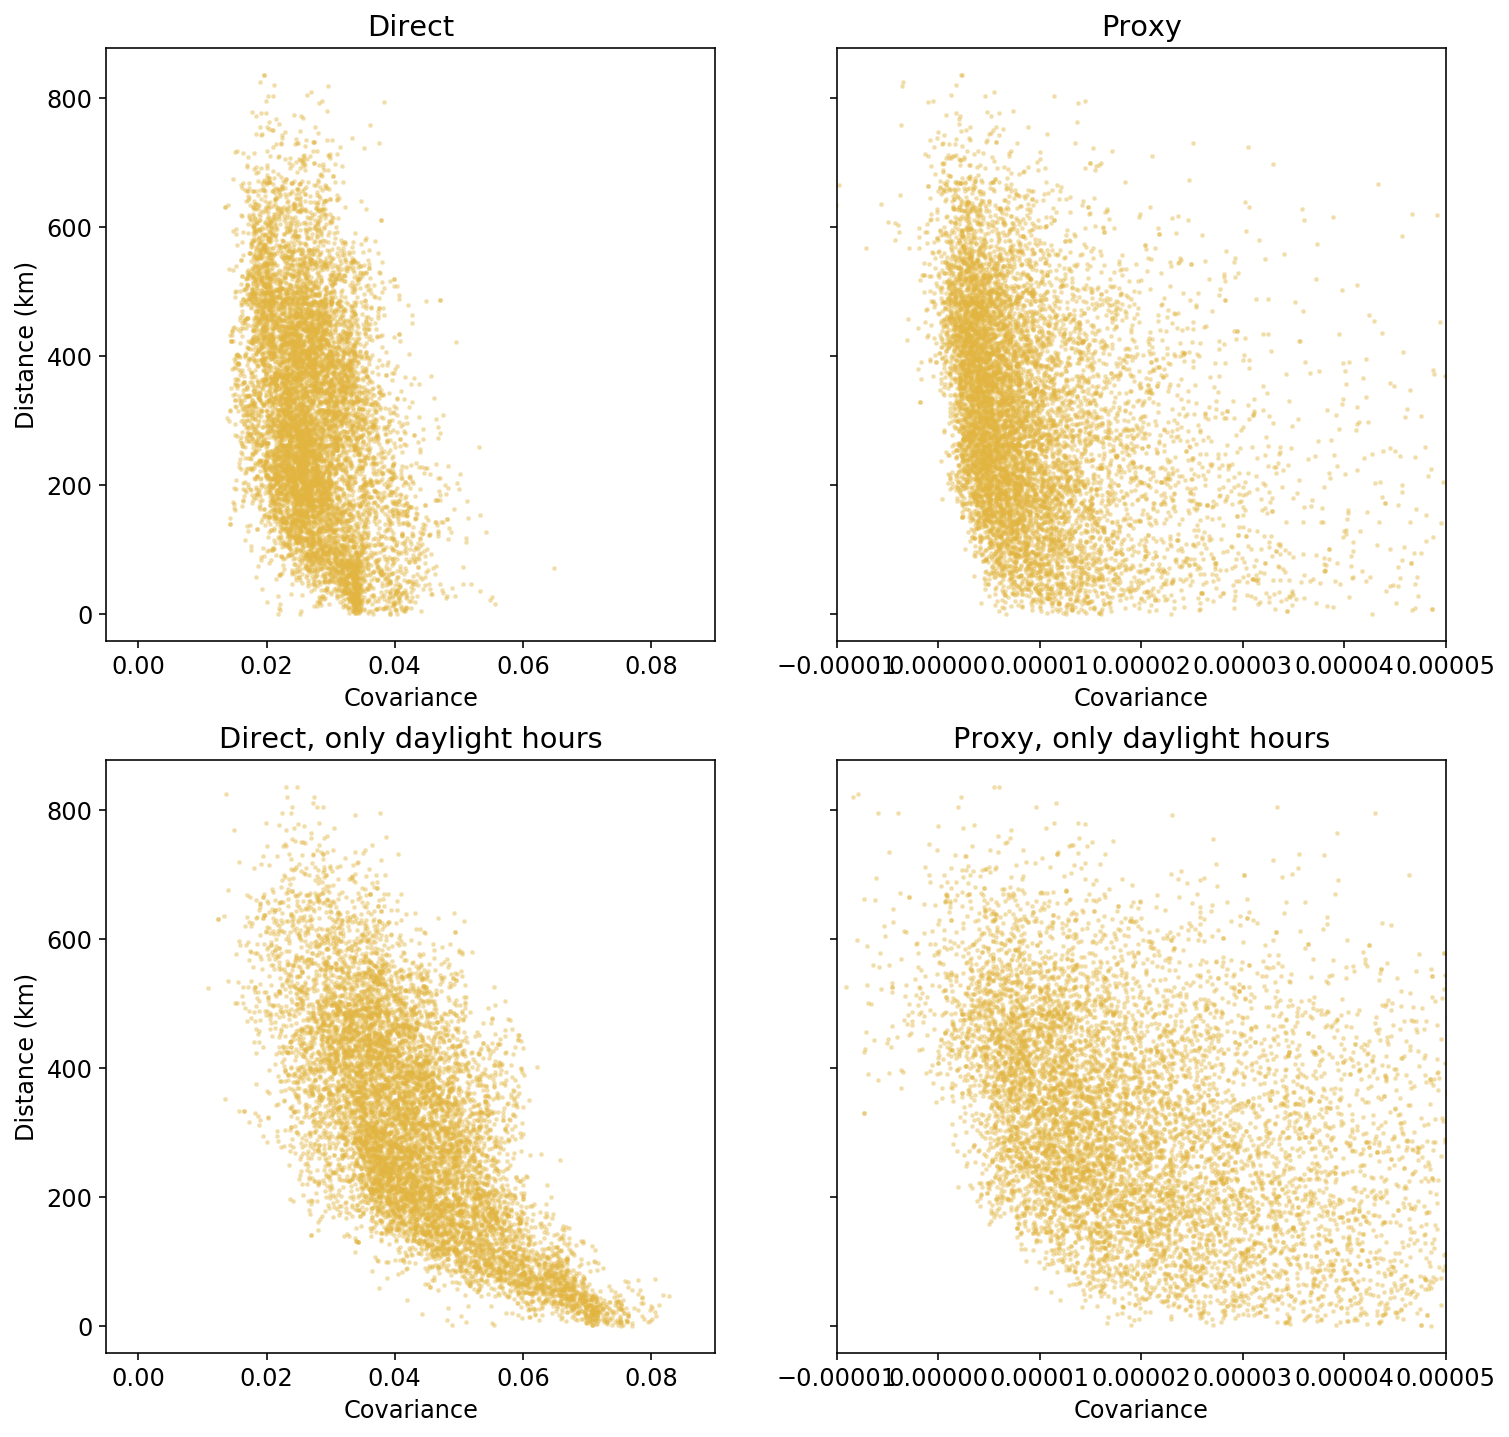

In [33]:
fig, ax = plt.subplots(2,2,figsize=(12,12),sharey=True)

plotargs = {"markersize":3, "c":"#e2b541", "alpha":0.3}

ax[0,0].plot(solar_genconvs, dists, ".", **plotargs)
ax[0,0].set_xlim(-0.005, 0.09)
ax[0,1].plot(solar_resconvs, dists, ".", **plotargs)
ax[0,1].set_xlim(-0.00001, 0.00005)
ax[1,0].plot(solar_gendaylightconvs, dists, ".", **plotargs)
ax[1,0].set_xlim(-0.005, 0.09)
ax[1,1].plot(solar_resdaylightconvs, dists, ".", **plotargs)
ax[1,1].set_xlim(-0.00001, 0.00005)

ax[0,0].set_ylabel("Distance (km)")
ax[1,0].set_ylabel("Distance (km)")

ax[0,0].set_xlabel("Covariance")
ax[0,1].set_xlabel("Covariance")
ax[1,0].set_xlabel("Covariance")
ax[1,1].set_xlabel("Covariance")

ax[0,0].set_title("Direct")
ax[0,1].set_title("Proxy")
ax[1,0].set_title("Direct, only daylight hours")
ax[1,1].set_title("Proxy, only daylight hours")